# Prevalence and Efficacy of Moderation

- What fraction of attacking users have been blocked for harassment?

- What fraction of attacking comments come from users blocked for harassment?

- What fraction of attacking comments were followed by a block event?

- How does the probability of a user being blocked change with the number of attacking comments?


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from load_utils import *

d = load_diffs()
df_events, df_blocked_user_text = load_block_events_and_users()

### Q: What fraction of attacking users have been blocked for harassment?

TODO: Also consider just registered users 

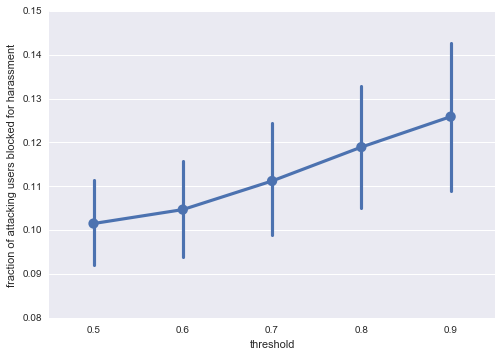

In [2]:
dfs = []
ts = np.arange(0.5, 0.91, 0.1)
for t in ts:
    dfs.append(\
                d['2015'].query('pred_recipient_score >= %f' % t)[['user_text', 'author_anon']]\
                .drop_duplicates()\
                .merge(df_blocked_user_text, how = 'left', on = 'user_text')\
                .assign(blocked = lambda x: x.blocked.fillna(0),
                        threshold = t)
               )
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', data = df)
plt.ylabel('fraction of attacking users blocked for harassment')

### Q: What fraction of attacking comments were followed by a block event?
Within one week

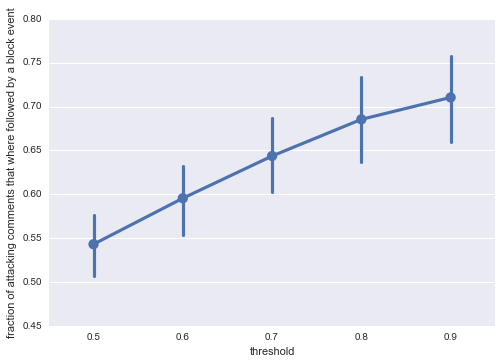

In [3]:
dfs = []
for t in ts:    
    dfs.append(
                d['2015'].query('pred_recipient_score >= %f' % t)\
                        .loc[:, ['user_text', 'rev_id', 'rev_timestamp']]\
                        .merge(df_events, how = 'left', on = 'user_text')\
                        .dropna(subset=['rev_timestamp', 'timestamp'])\
                        .assign(delta = lambda x: (x['timestamp'] - x['rev_timestamp']))\
                        .assign(blocked= lambda x: (x['delta'] <  pd.Timedelta('7 days')) & (x['delta'] >  pd.Timedelta('0 seconds')))\
                        .drop_duplicates(subset = 'rev_id')\
                        .assign(threshold = t)
                )
ax = sns.pointplot(x='threshold', y='blocked', data = pd.concat(dfs))
plt.xlabel('threshold')
plt.ylabel('fraction of attacking comments that where followed by a block event')

### Q: What fraction of attacking comments come from users blocked for harassment?

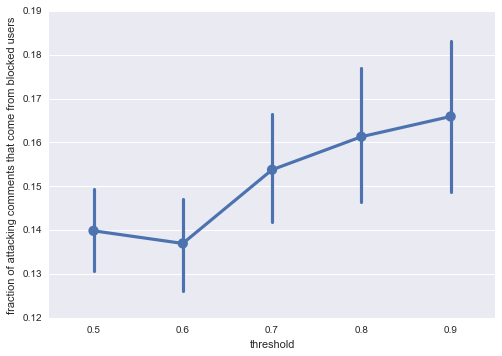

In [4]:
dfs = []


for t in ts:
    dfs.append(\
                d['2015'].query('pred_recipient_score >= %f' % t)[['rev_id', 'author_anon']]\
                .merge(d['blocked'], how = 'left', on = 'rev_id')\
                .assign(blocked = lambda x: x.blocked.fillna(0),
                        threshold = t)
               )
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', data = df)
plt.ylabel('fraction of attacking comments that come from blocked users')

### Q: How does the probablity of a user being blocked change with the number of attacking comments?

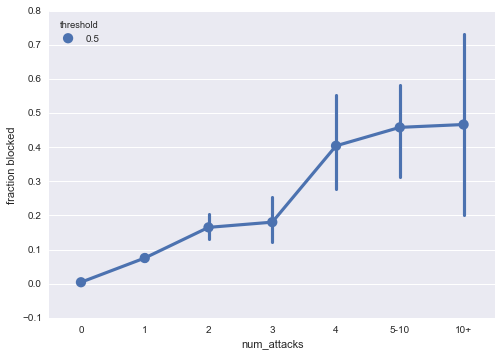

In [5]:
def remap(x):
    if x < 5:
        return str(int(x))
    if x < 10:
        return '5-10'
    else:
        return '10+'
    
t = 0.5 

        
d_temp = d['2015'].assign(attack = lambda x: x.pred_recipient_score >=  t)\
                .groupby('user_text', as_index = False)['attack'].sum()\
                .rename(columns={'attack':'num_attacks'})\
                .merge(df_blocked_user_text, how = 'left', on = 'user_text')\
                .assign(
                    blocked = lambda x: x.blocked.fillna(0,),
                    num_attacks = lambda x: x.num_attacks.apply(remap),
                    threshold = t)
                
ax = sns.pointplot(x='num_attacks', y= 'blocked', data=d_temp, hue = 'threshold', order = ('0', '1', '2', '3', '4', '5-10', '10+'))
plt.ylabel('fraction blocked')

# Blocked Users

### Summary Stats

In [6]:
print('# block events:')
df_events.shape[0]

# block events:


27343

In [7]:
print('# block events')
df_events.groupby('anon').size()

# block events


anon
False    12377
True     14966
dtype: int64

In [8]:
print('# blocked users')
df_events.groupby('anon').user_text.nunique()

# blocked users


anon
False    10106
True     13562
Name: user_text, dtype: int64

In [9]:
print('# blocked users with a public user talk comment')
d['blocked'].groupby('author_anon').user_text.nunique()

# blocked users with a public user talk comment


author_anon
False    6134
True     6942
Name: user_text, dtype: int64

In [10]:
print('fraction of blocked users with a public user talk comment')
d['blocked'].groupby('author_anon').user_text.nunique() / df_events.groupby('anon').user_text.nunique() 

fraction of blocked users with a public user talk comment


author_anon
False    0.606966
True     0.511871
Name: user_text, dtype: float64

### Q: How many users got blocked multiple times?

In [11]:
df_events.assign(block_count = 1)\
.groupby(['user_text', 'anon'], as_index = False)['block_count'].sum()\
.groupby(['anon', 'block_count']).size()

anon   block_count
False  1               8568
       2               1135
       3                235
       4                 91
       5                 42
       6                 16
       7                  8
       8                  5
       9                  3
       10                 1
       15                 1
       16                 1
True   1              12416
       2                964
       3                136
       4                 32
       5                  5
       6                  5
       7                  3
       10                 1
dtype: int64

### How many user talk comments before first block event?

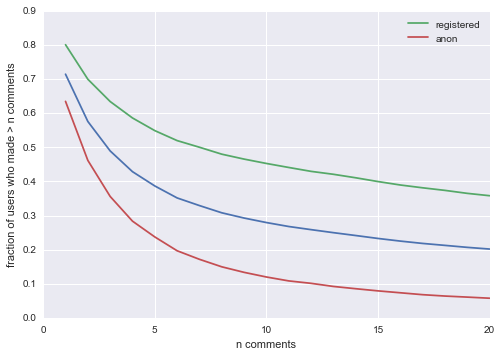

In [12]:
df_first_block = df_events.sort('timestamp')\
                    .groupby(['user_text'], as_index=False).first()[['user_text', 'timestamp']]
    

df_counts = d['blocked'].merge(df_first_block, how = 'inner', on = 'user_text')\
                .assign(delta = lambda x: (x['timestamp'] - x['rev_timestamp']).apply(lambda x: x.days) + 1)\
                .query('delta >=1')
        
def atleast(s):
    s = s.value_counts().value_counts().sort_index()
    n = s.sum()
    return 1 - s.cumsum()/n

s = atleast(df_counts['user_text'])
sr = atleast(df_counts.query('not author_anon')['user_text'])
sa = atleast(df_counts.query('author_anon')['user_text'])

plt.plot(s.head(20), label = '')
plt.plot(sr.head(20), label = 'registered')
plt.plot(sa.head(20), label = 'anon')

plt.xlabel('n comments')
plt.ylabel('fraction of users who made > n comments')
plt.legend()

### How long are users around before their first block event?

In [14]:
d_first_post = d['blocked'].sort('rev_timestamp', inplace= False)\
                    .groupby(['user_text', 'author_anon'], as_index=False).first()\
                    [['user_text', 'author_anon', 'rev_timestamp']]

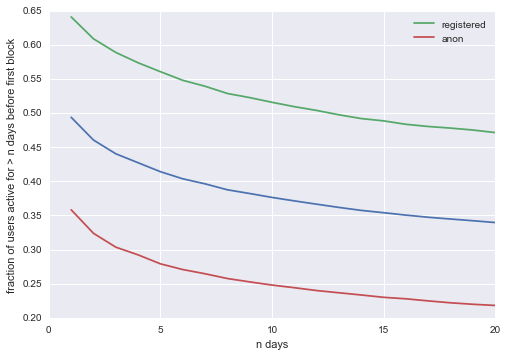

In [15]:

        
df_first_block = df_events.sort('timestamp')\
                    .groupby(['user_text'], as_index=False).first()[['user_text', 'timestamp']]
    

d = d_first_post.merge(df_first_block, how = 'inner', on = 'user_text')\
                .assign(delta = lambda x: (x['timestamp'] - x['rev_timestamp']).apply(lambda x: x.days) + 1)\
                .query('delta >=1')
        
def atleast(s):
    s = s.value_counts().sort_index()
    n = s.sum()
    return 1 - s.cumsum()/n

s = atleast(d['delta'])
sr = atleast(d.query('not author_anon')['delta'])
sa = atleast(d.query('author_anon')['delta'])

plt.plot(s.head(20), label = '')
plt.plot(sr.head(20), label = 'registered')
plt.plot(sa.head(20), label = 'anon')
plt.legend()

plt.xlabel('n days')
plt.ylabel('fraction of users active for > n days before first block')
plt.legend()

## What influence does being blocked have on user behavior?

### Q: P(blocked again | blocked at least k times)

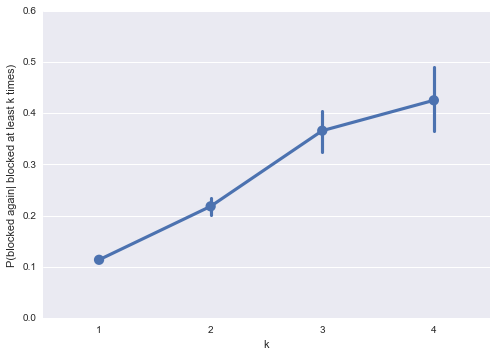

In [16]:
dfs = []

for k in range(1, 5):
    df_k = df_events.assign(blocked = 1)\
            .groupby('user_text', as_index = False)['blocked'].sum()\
            .query('blocked >=%f'%k)
    df_k1 = df_events.assign(blocked = 1)\
            .groupby('user_text', as_index = False)['blocked'].sum()\
            .query('blocked >=%f'%(k+1))\
            .assign(again = 1)
    df = df_k.merge(df_k1, how = 'left', on = 'user_text').assign(again = lambda x: x.again.fillna(0)).assign(k=k)
    dfs.append(df)

sns.pointplot(x = 'k', y = 'again', data = pd.concat(dfs))
plt.xlabel('k')
plt.ylabel('P(blocked again| blocked at least k times)')

### Q: How does the number of block events vary over time?

TODO: use compare_groups

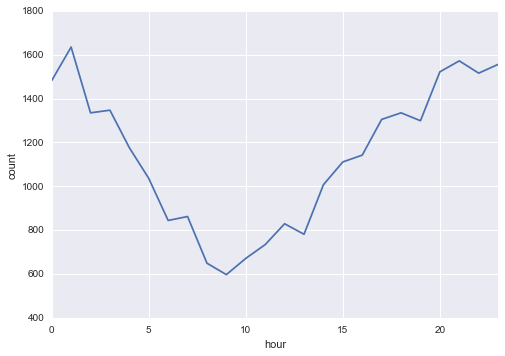

In [17]:
df_events.hour.value_counts().sort_index().plot()
plt.xlabel('hour')
plt.ylabel('count')

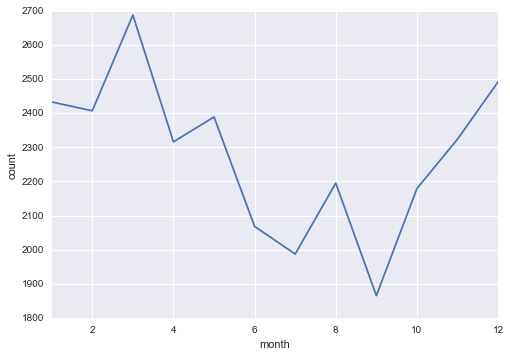

In [18]:
df_events.month.value_counts().sort_index().plot()
plt.xlabel('month')
plt.ylabel('count')

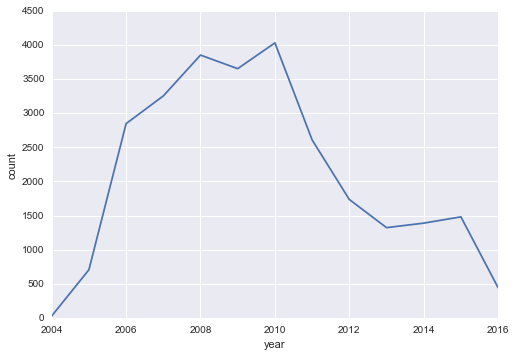

In [19]:
df_events.year.value_counts().sort_index().plot()
plt.xlabel('year')
plt.ylabel('count')

### How many blocked users have a public talk page comment after they where blocked?

In [20]:
#TODO